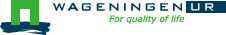



# Erwin - EnKF


In [1]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

from pathlib import Path

data_dir = Path.cwd() / "data"

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

This notebook was built with:
python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
PCSE version: 5.5.6


In [2]:
from pcse.fileinput import YAMLCropDataProvider

cropd = YAMLCropDataProvider()
cropd.print_crops_varieties()

crop 'barley', available varieties:
 - 'Spring_barley_301'
crop 'cassava', available varieties:
 - 'Cassava_VanHeemst_1988'
crop 'chickpea', available varieties:
 - 'Chickpea_VanHeemst_1988'
crop 'cotton', available varieties:
 - 'Cotton_VanHeemst_1988'
crop 'cowpea', available varieties:
 - 'Cowpea_VanHeemst_1988'
crop 'fababean', available varieties:
 - 'Faba_bean_801'
crop 'groundnut', available varieties:
 - 'Groundnut_VanHeemst_1988'
crop 'maize', available varieties:
 - 'Maize_VanHeemst_1988'
 - 'Grain_maize_201'
 - 'Grain_maize_202'
 - 'Grain_maize_203'
 - 'Grain_maize_204'
 - 'Grain_maize_205'
 - 'Fodder_maize_nl'
crop 'millet', available varieties:
 - 'Millet_VanHeemst_1988'
crop 'mungbean', available varieties:
 - 'Mungbean_VanHeemst_1988'
crop 'pigeonpea', available varieties:
 - 'Pigeonpea_VanHeemst_1988'
crop 'potato', available varieties:
 - 'Potato_701'
 - 'Potato_702'
 - 'Potato_703'
 - 'Potato_704'
 - 'Innovator'
 - 'Fontane'
 - 'Markies'
 - 'Premiere'
 - 'Festien'
cro

In [12]:
cropd.set_active_crop('potato', 'Innovator')

V2) Reading file

In [13]:
from pcse.fileinput import CABOFileReader

In [4]:

#cropfile = data_dir / "crop" / "SUG0601.crop"
#cropd = CABOFileReader(cropfile)

### Soil parameters
The soildata dictionary provides the parameter name/value pairs related to the soil type and soil physical properties. The number of parameters is variable depending on the soil water balance type that is used for the simulation. For this example, we will use the water balance for freely draining soils and use the soil file for medium fine sand: `ec3.soil`. This file is also taken from the soil files in the [WOFOST Control Centre](http://www.wageningenur.nl/wofost).

Based on the soil texture and available water capacity (AWC) data provided, you should select the soil type that closely matches your own soil's characteristics. Your soil is described as a silty clay with an AWC max of 90 mm. Below is an analysis of the options:

### Texture Class Options
1. **Texture 1-Coarse (AWC = 150 mm)**
2. **Texture 2-Medium (AWC = 220 mm)**
3. **Texture 3-Medium Fine (AWC = 250 mm)**
4. **Texture 4-Fine (AWC = 190 mm)**
5. **Texture 5-Very Fine (AWC = 130 mm)**

### EC Class Options
1. **EC1-Coarse**
2. **EC2-Medium**
3. **EC3-Medium Fine**
4. **EC4-Fine**
5. **EC5-Very Fine**
6. **EC6-Fine and Permeable (Peat)**

Given the provided AWC values and soil moisture characteristics, here is the analysis:

### Comparison with Your Soil
Your soil is a silty clay with an AWC max of 90 mm. This implies that your soil retains less water compared to the options provided. Therefore, choosing a soil texture with a closer AWC and moisture characteristics is important.

### Detailed Comparison

#### Texture Class
- **Texture 1-Coarse (AWC = 150 mm)**: Not ideal as it has a much higher AWC.
- **Texture 2-Medium (AWC = 220 mm)**: Too high AWC.
- **Texture 3-Medium Fine (AWC = 250 mm)**: Highest AWC, not suitable.
- **Texture 4-Fine (AWC = 190 mm)**: High AWC but closer than the previous options.
- **Texture 5-Very Fine (AWC = 130 mm)**: Still high but lower than others, except Texture 1.

#### EC Class
- **EC1-Coarse**: Similar characteristics to Texture 1.
- **EC2-Medium**: Too high AWC.
- **EC3-Medium Fine**: High AWC.
- **EC4-Fine**: High AWC but closer.
- **EC5-Very Fine**: Closer to your soil characteristics, but still has higher AWC.
- **EC6-Fine and Permeable (Peat)**: High AWC, suitable for highly organic soils.

### Recommended Choice
Given the AWC max of 90 mm in your soil, the best choice would be:

- **Texture 5-Very Fine (AWC = 130 mm)**
- **EC5-Very Fine**

While these still have a higher AWC than your soil, they are closer in comparison to the other options.

### Additional Considerations
Since the soil texture impacts many factors beyond just AWC, including soil workability, aeration, and water retention, you might need to calibrate or adjust the parameters slightly in your model to better match your silty clay soil's specific characteristics.

**Final Recommendation**: Choose **Texture 5-Very Fine** or **EC5-Very Fine** for the most similar characteristics to your silty clay soil with an AWC max of 90 mm.

In [14]:
import pandas as pd

df = pd.read_csv("data/Data 2022/Probes/Sonde Rampe 1.csv", sep=";")
df['Date/heure'] = pd.to_datetime(df['Date/heure'], format="%Y-%m-%d %H:%M:%S")
df = df.sort_values(by='Date/heure').reset_index(drop=True)
for column in df.columns:
    if column not in ['Date/heure', 'Batterie [mV]', 'Panneau solaire [mV]'] :
        df[column] = df[column].str.replace(',', '.').astype(float)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 2.0, 'SMLIM': 0.4}


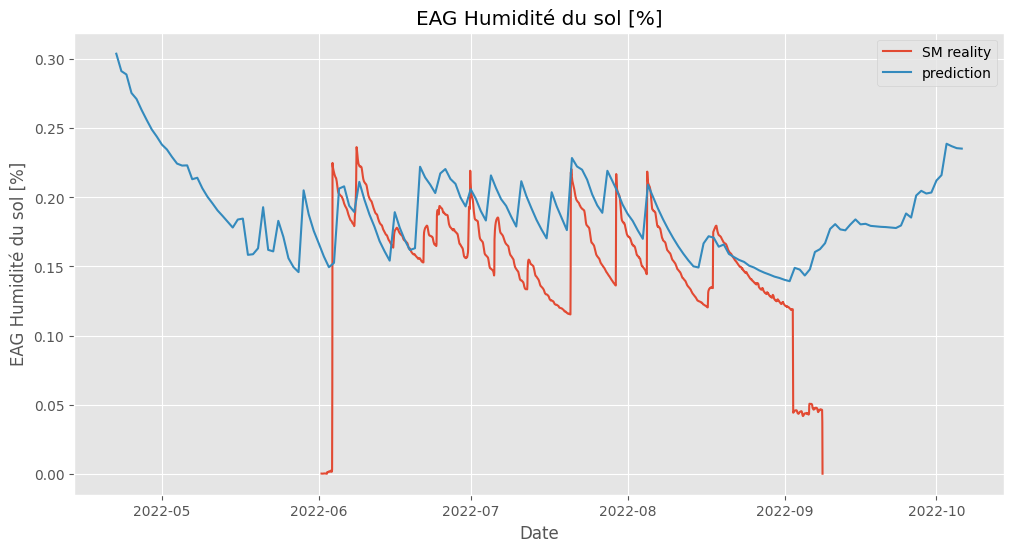

In [61]:
soilfile = data_dir / "soil" / "ec3.soil"
soild = CABOFileReader(soilfile)


from pcse.util import WOFOST72SiteDataProvider
sited = WOFOST72SiteDataProvider(WAV=2)
print(sited)

from pcse.base import ParameterProvider
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

from pcse.fileinput import YAMLAgroManagementReader
agromanagement_file = data_dir / "agro" / "osiris_markies_rampe.agro"
agromanagement = YAMLAgroManagementReader(agromanagement_file)


from pcse.db import NASAPowerWeatherDataProvider
weatherdataprovider = NASAPowerWeatherDataProvider(latitude=49.5652319502033, longitude=2.4757816885380457)

from pcse.models import Wofost72_WLP_FD, Wofost72_PP
wofost = Wofost72_WLP_FD(parameters, weatherdataprovider, agromanagement)

wofost.run_till_terminate()
df_reality = pd.DataFrame(wofost.get_output())

df_reality = df_reality.set_index("day")



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

df_downsample = df#[df['Date/heure'].dt.hour == 19]

df_downsample['SM_reality'] = ((df_downsample['EAG Humidité du sol 2 [%]'] + df_downsample['EAG Humidité du sol 1 [%]'])/2) / 100

#for i in range(1, 7):
#    column_name = f'EAG Humidité du sol {i} [%]'
#    plt.plot(df_downsample['Date/heure'],df_downsample[column_name]/100, label=column_name)
plt.plot(df_downsample['Date/heure'], df_downsample['SM_reality'], label = 'SM reality')
plt.plot(df_reality.index, df_reality['SM'], label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()


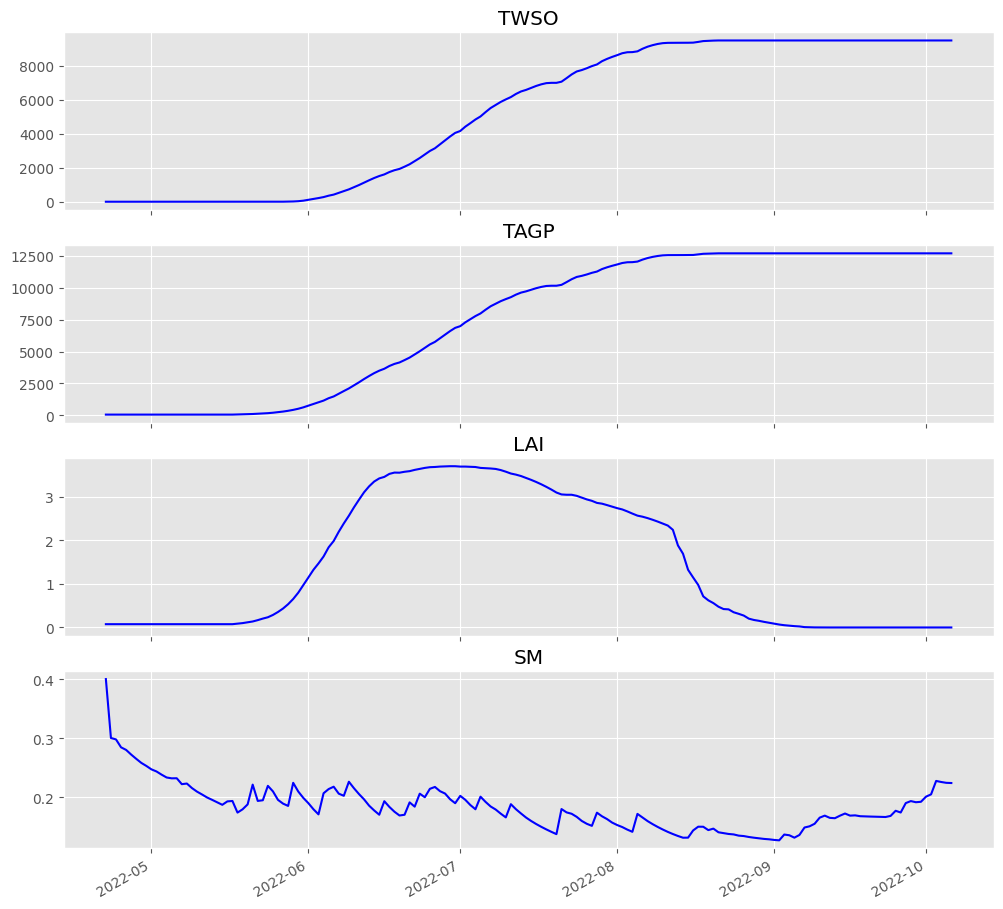

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,12), sharex=True)
for var, ax in zip(["TWSO", "TAGP", "LAI", "SM",], axes.flatten()):
    ax.plot_date(df_reality.index, df_reality[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()

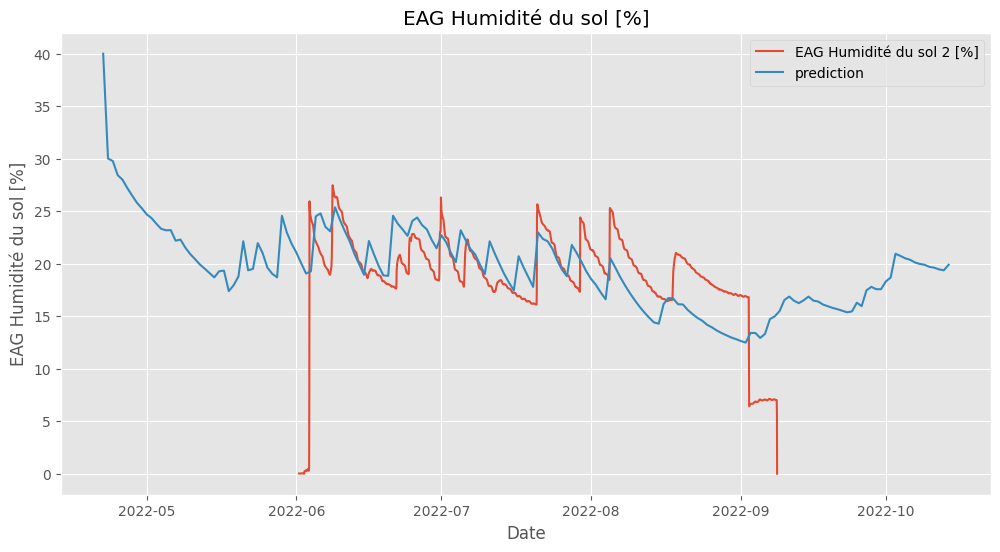

In [154]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(2, 3):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df['Date/heure'],df[column_name], label=column_name)
plt.plot(df_reality.index, df_reality['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()


# Création de fausses observations

On va supposer que la courbe précédente correspond exactement à la réalité. 

On va supposer que l'on effectue des mesures à intervalle de temps régulier, qu'on spécifie ici. On ajoute alors un bruit sur les observations

For this exercise, we assume that we have observations on both leaf area index ("LAI") and volumetric soil moisture ("SM"). Operationally such data could be retrieved from the MODIS LAI product and the soil moisture products from the scatterometer onboard METOP. Next to the observations itself, we have to provide a standard deviation of the estimated value as a measure of the uncertainty of the observation. 

For this example, we will assume that the LAI estimates have a standard deviation of 10% of the estimated value. This is relatively small compared to the uncertainty reached by typical satellite LAI products which is more in the order of 20%. For the soil moisture observations, we assume a standard deviation of 5% of the simulated value.

In [63]:
import math, random

INTERVALLE_OBSERVATIONS = 15 # Nombre de jours entre chaque mesure
ERREUR = 0.05 # Erreur max à introduire, en pourcentage

variables_for_DA = ["LAI", "SM"]

dates_of_observation = []
observed_lai = []
observed_sm = []

nbSkippedDay = 0
for index, row in df_reality.iterrows():
    day = index
    lai = row['LAI']
    sm = row['SM']

    if nbSkippedDay < INTERVALLE_OBSERVATIONS:
        nbSkippedDay += 1
        continue
    if math.isnan(lai) or math.isnan(sm):
        continue

    dates_of_observation.append(day)



    observed_lai.append(random.uniform(lai * (1-ERREUR), lai * (1+ERREUR)))
    observed_sm.append(random.uniform(sm * (1-ERREUR), sm * (1+ERREUR)))

    nbSkippedDay = 0

observed_lai = np.array(observed_lai)
observed_sm = np.array(observed_sm)


std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                 
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value


"""
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])                                                
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
"""

observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]

### 2.2.3 Plot modelled and observed states
We will now combine the default WOFOST run and the satellite observations in a single figure.

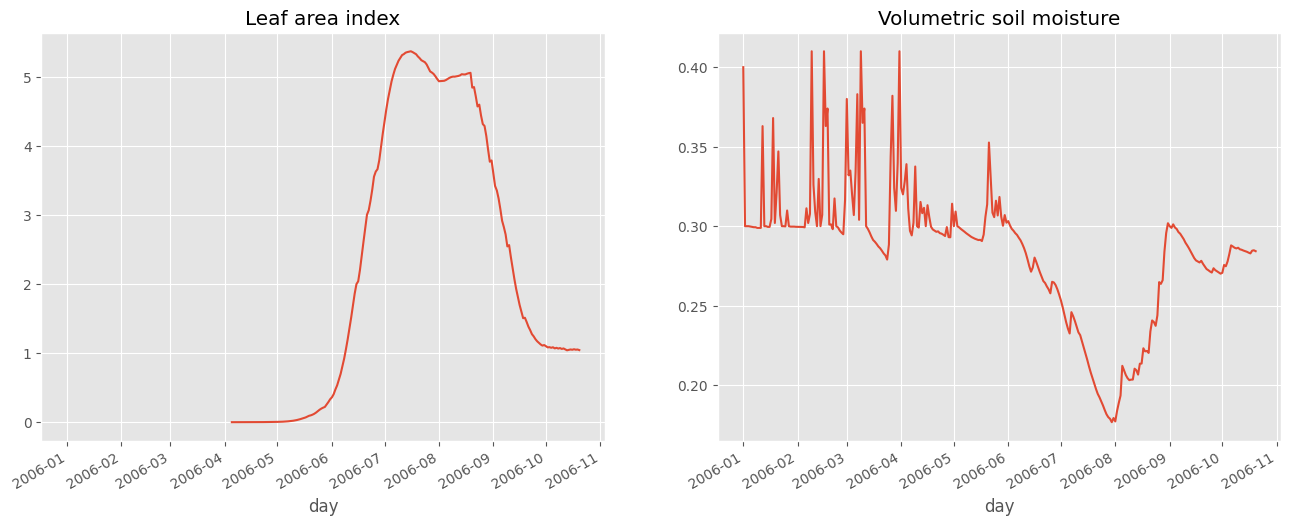

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df_reality["LAI"].plot(ax=axes[0], label="leaf area index")
#axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df_reality["SM"].plot(ax=axes[1], label="rootzone soil moisture")
#axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

## 2.3 Setting up the ensemble

### 2.3.1 The size of the ensemble
First we define the size of the ensemble, tests have demonstrated that for crop models like WOFOST an ensemble 
of size 50 is sufficient to represent the uncertainty in the model. Next, we set the random seed in order to have a reproducible sequence of random numbers. 

In [129]:
ensemble_size = 50
np.random.seed(10000)

### 2.3.2 Defining variability in the ensemble

On va supposer que ces variables sont les vraies valeurs. On va imaginer qu'on ne les connaît pas avec certitude ensuite et on va voir à quel point notre modèle est capable de retrouver ces valeurs

The purpose of the ensemble is to represent uncertainty in the simulated states. Therefore, we have to think carefully how we will generate the ensemble in order to have a representative amount of variability within the ensemble. In practice, this means that we have to enforce uncertainty on parameters, weather data and/or agromanagement. 

Choosing the most uncertain parts of your system is not straightforward and differs from case to case. For studies at field scale and with local weather data available, it is most likely that most of the variability comes from uncertainty in the parameter values or even in the model structure (not treated here). For regional applications, it is more likely that uncertainty in weather inputs as well as soil data and agromanagement (unknown sowing dates) play a major role. 

A sensitivity analysis (SA) of the model can be helpful in identifying uncertain parameters. However, SA should be applied carefully, as it can easily lead to wrong conclusions, particularly if boundaries of parameters are poorly choosen.

For the purpose of this tutorial, we will assume the model uncertainty comes from the following model parameters:
 - Initial conditions like the initial biomass (TDWI) and initial soil water amount (WAV).
 - Parameters values like the life span of leaves (SPAN) and the field capacity of the soil (SMFCF).
 
These four parameters will be treated as Gaussian random variables with a mean equal to the default value and a standard deviation which is guessed from experience with the model. Each ensemble member will receive a value for the respective parameter which is drawn from the distribution of each parameter and this value will override the default value.

In [130]:
print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 0.51
WAV 10.0
SPAN 35.0
SMFCF 0.3


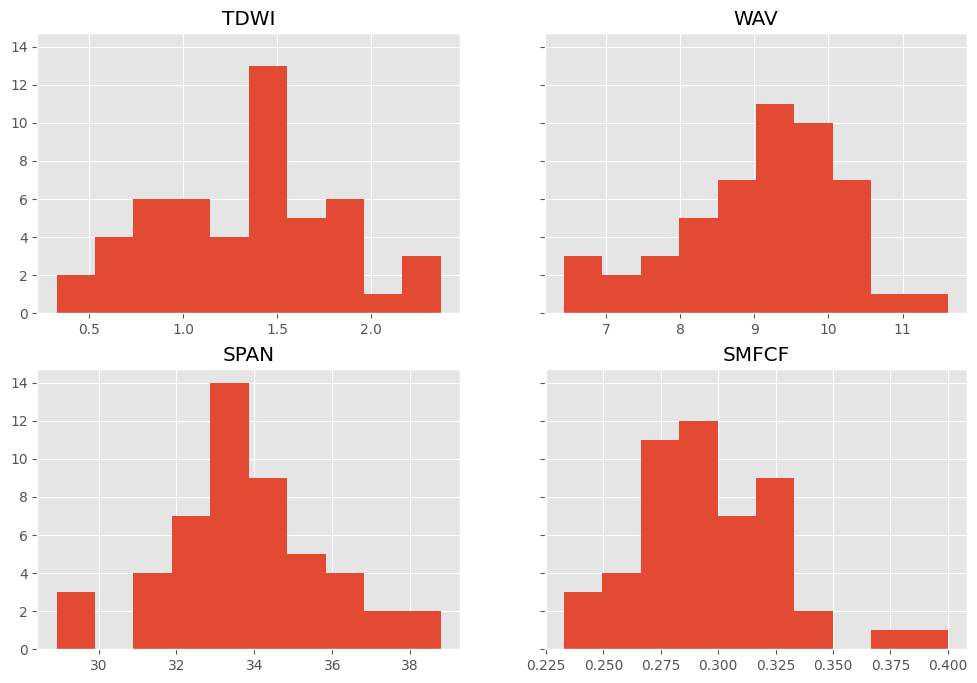

In [131]:
# A container for the parameters that we will override

PARAMETERS_BEFORE = {}
PARAMETERS_BEFORE["TDWI"] = 1.
PARAMETERS_BEFORE["WAV"] = 9.
PARAMETERS_BEFORE["SPAN"] = 34
PARAMETERS_BEFORE["SMFCF"] = 0.3

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(1.4, 0.5, (ensemble_size))
override_parameters["WAV"] = np.random.normal(9., 1.0, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(34, 2 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.3, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

### 2.3.3 Initializing the ensemble

The python code below initializes an ensemble of WOFOST models which are collected in the list named `ensemble`. Each ensemble member receives distinct values for the four parameters defined above, all other parameters are equal for all ensemble members. Note that after the initialization step, no simulation has been carried out. All members are waiting in their initial state and need to be instructed explicitly to carry out the actual simulation.

In [132]:
p = copy.deepcopy(parameters)
for par, distr in PARAMETERS_BEFORE.items():
    print(par, distr)
    p.set_override(par, distr)
wofost_before =  Wofost72_WLP_FD(p, weatherdataprovider, agromanagement)

TDWI 1.0
WAV 9.0
SPAN 34
SMFCF 0.3


In [133]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weatherdataprovider, agromanagement)
    ensemble.append(member)

## 2.4. Implementing the data assimilation itself
First, we define if we want to see detailed output, disabling output makes the notebook more compact as long tables will not be shown.

In [134]:
show_output = True

### 2.4.1 Move the ensemble forward in time until the first analysis step
First we take the first observation from the set of observations. Next, we will instruct each ensemble member to move forward in time (simulate the crop) up till the date where the first observation is available. The latter is done with the `run_till()` function on each member.

In [135]:
while(len(observations_for_DA) > 0):
    day, obs = observations_for_DA.pop(0)
    for member in ensemble:
        member.run_till(day)
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations_for_DA))

    collected_states = []
    for member in ensemble:
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A).T

    # Show first 5 rows if output
    df_A.head(5) if show_output else None
        
    P_e = np.matrix(df_A.cov())
    df_A.cov() if show_output else None

    perturbed_obs = []
    for state in variables_for_DA:
        (value, std) = obs[state]
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())

    # Show first 5 rows of perturbed observations if output
    df_perturbed_obs.head(5) if show_output else None

    # Here we compute the Kalman gain
    H = np.identity(len(obs))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)
    K if show_output else None

    # Here we compute the analysed states
    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    df_Aa.head(5) if show_output else None
    
    for member, new_states in zip(ensemble, df_Aa.itertuples()):
        r1 = member.set_variable("LAI", new_states.LAI)
        r2 = member.set_variable("SM", new_states.SM)

Ensemble now at day 2006-04-05
12 observations left!
Ensemble now at day 2006-04-21
11 observations left!
Ensemble now at day 2006-05-07
10 observations left!
Ensemble now at day 2006-05-23
9 observations left!
Ensemble now at day 2006-06-08
8 observations left!
Ensemble now at day 2006-06-24
7 observations left!
Ensemble now at day 2006-07-10
6 observations left!
Ensemble now at day 2006-07-26
5 observations left!
Ensemble now at day 2006-08-11
4 observations left!
Ensemble now at day 2006-08-27
3 observations left!
Ensemble now at day 2006-09-12
2 observations left!
Ensemble now at day 2006-09-28
1 observations left!
Ensemble now at day 2006-10-14
0 observations left!


### 2.4.8 Run all the ensemble members until the end of the growing season

Finally, we can run the WOFOST ensemble until the end of the growing season using the `run_till_terminate()` call.

In [136]:
for member in ensemble:
    member.run_till_terminate()
wofost_before.run_till_terminate()

df_before = pd.DataFrame(wofost_before.get_output())
df_before = df_before.set_index("day")

# 3. Visualizing output from the ensemble with the EnKF
## 3.1 Retrieve output from the ensemble

First we retrieve the simulated output from each ensemble member and convert it into a dataframe.

In [137]:
results = [pd.DataFrame(member.get_output()).set_index("day") for member in ensemble]

## 3.2 Visualize ensemble with EnKF

Now we plot the simulated output for the variables LAI and SM for each ensemble member into a graph. This clearly shows the impact of the observations on the simulated values. At each time step where an observation of LAI is available, the ensemble is moved towards the observation and the uncertainty in the ensemble is reduced as is demonstrated from the reduction of the variability in the simulated ensemble. After each analysis step the ensemble variance increasing again up till the next step.

However for the soil moisture (SM) we see a different pattern: for the first two observations there is a clear response as the ensemble moves towards the observation and the ensemble variance is reduced. However, for the last three observations there is hardly an impact. This phenomenon is called *filter divergence* and it happens when the variability in the ensemble becomes so small that there is no response of the filter on the observed data. In this case, the first two observations already strongly reduce the ensemble variance. On top of this, all ensemble members are moving towards a low soil moisture level as a result of the crop pulling water out of the soil. Thus, all members converge towards a low soil moisture with a very small variance and no impact of the EnKF anymore. The solution for this problem would be to either artificially inflate the variance or introduce uncertainty in rainfall inputs (use an ensemble of rainfall values) which will boost the uncertainty in the simulated soil moisture. See for example my [paper on simulating rainfall uncertainty](https://doi.org/10.1175/2008JHM899.1).

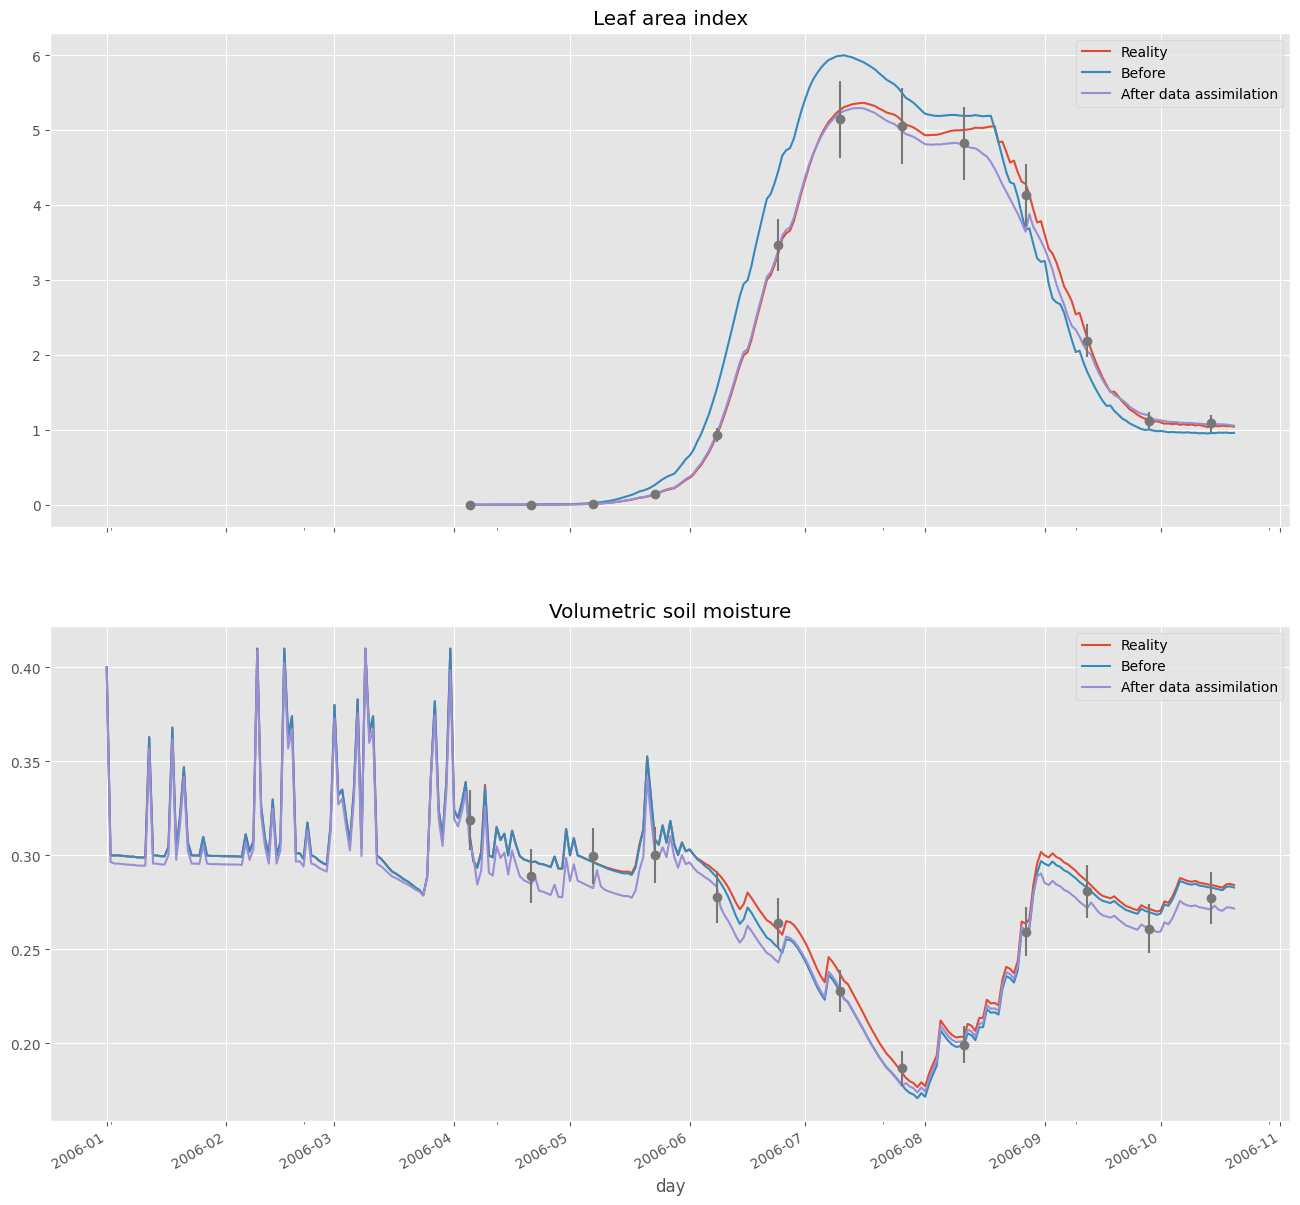

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16), sharex=True)
#for member_df in results:
#    member_df["LAI"].plot(style="k:", ax=axes[0])
#    member_df["SM"].plot(style="k:", ax=axes[1])
df_reality["LAI"].plot(ax=axes[0], label="Reality")
df_reality["SM"].plot(ax=axes[1], label="Reality")

df_before["LAI"].plot(ax=axes[0], label="Before")
df_before["SM"].plot(ax=axes[1], label="Before")

concatenated_df = pd.concat([df['LAI'] for df in results], axis=1)
concatenated_df.mean(axis=1).plot(ax=axes[0], label="After data assimilation")
concatenated_df = pd.concat([df['SM'] for df in results], axis=1)
concatenated_df.mean(axis=1).plot(ax=axes[1], label="After data assimilation")

axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

axes[0].legend()
axes[1].legend()

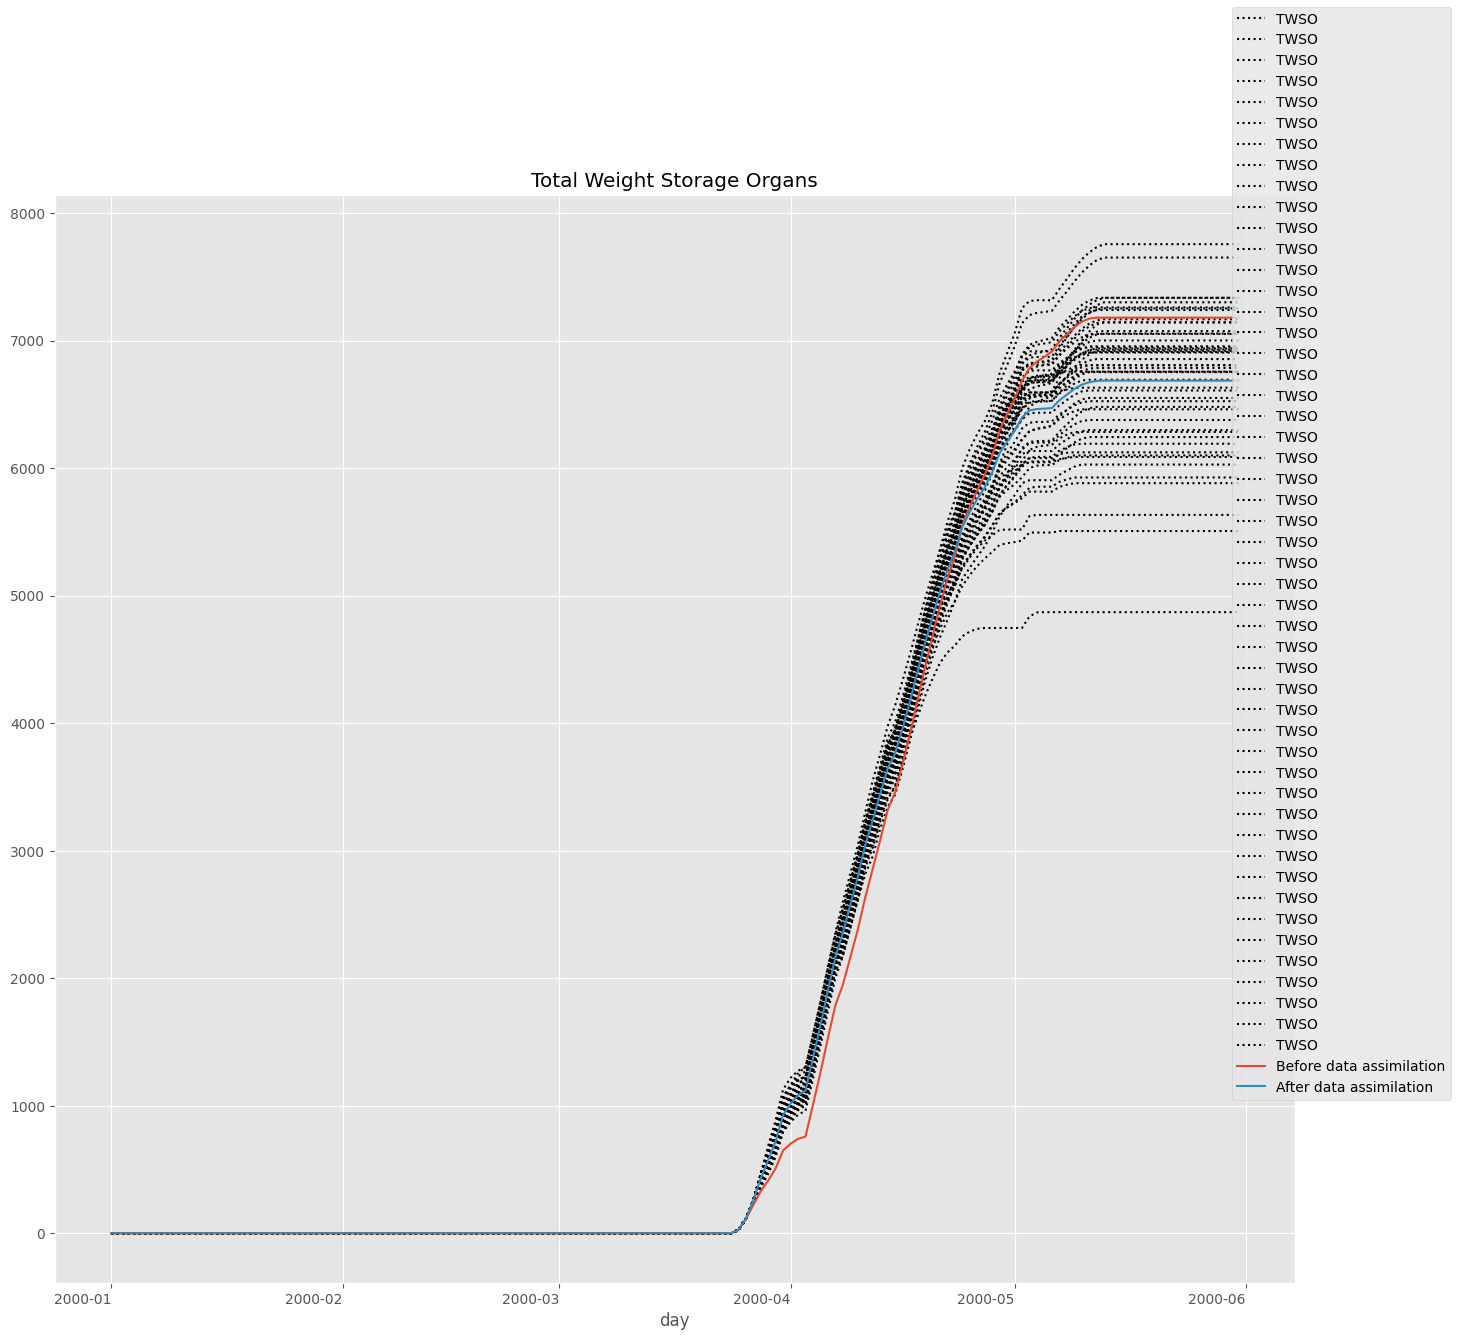

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,16), sharex=True)
for member_df in results:
    member_df["TWSO"].plot(style="k:", ax=axes, label=None)
axes.set_title("Total Weight Storage Organs")
fig.autofmt_xdate()

df["TWSO"].plot(ax=axes, label="Before data assimilation")

concatenated_df = pd.concat([df['TWSO'] for df in results], axis=1)
concatenated_df.mean(axis=1).plot(ax=axes, label="After data assimilation")

fig.legend()

In [13]:
import random

random.randint(0, 9)

6